## 0.Getting Setup


We will be using `torchvision` v0.13(available as of July 2022) and `torch` should be 1.12+ version

In [ ]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 1.12.1+cu113
torchvision version: 0.13.1+cu113


In [ ]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 3107, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 3107 (delta 14), reused 24 (delta 8), pack-reused 3067
Receiving objects: 100% (3107/3107), 640.08 MiB | 17.03 MiB/s, done.
Resolving deltas: 100% (1766/1766), done.
Checking out files: 100% (218/218), done.


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1.Getting data

Our goal is to deploy the best model for our FoodVision Mini problem, let's start by downloading the 20% pizza, steak and sushi dataset and train our different models with feature extraction and then compare them.

In [ ]:
# Download pizza, steak, shushi images from Github
# Leveraging the 'download_data' function 
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")
data_20_percent_path


[INFO] Did not find data/pizza_steak_sushi_20_percent directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...


PosixPath('data/pizza_steak_sushi_20_percent')

In [ ]:
# Setup directory paths 
train_dir = data_20_percent_path / 'train'
test_dir = data_20_percent_path / 'test'

## 2.FoodVision Mini Model Deployment expereiment outline

The ideal deployed model FoodVision Mini performs well and fast.

We'd like our model to perform as close to real-time as possible.

Real-time in this case being ~30FPS (frames per second) because that's about how fast the human eye can see (there is debate on this but let's just use ~30FPS as our benchmark).

And for classifying three different classes (pizza, steak and sushi), we'd like a model that performs at 95%+ accuracy.

Of course, higher accuracy would be nice but this might sacrifice speed.

So our goals are:

1. **Performance** - A model that performs at 95%+ accuracy.
2. **Speed** - A model that can classify an image at ~30FPS (0.03 seconds inference time per image, also known as latency).

## 3.Creating an EffNetB2 feature extractor

To do so we can:
1. Setup the pretrained weigths as `weights=torchvision.models.EfficientNet_B2_Wegiths.DEFAULT`, where "`DEFAULT`" means "best currently available"(or could use `weights="DEFAULT"`).
2. Get the pretrained model image transforms from the weights with the `transform()` method (we need these so we can convert our images into the same format as the pretrained EffNetB2 was trained on)
3. Create a pretrained model instance by passing the weights to an instance of `torchvision.models.efficientnet_b2`
4. Freeze the base layer in the model
5. Update the classifier head to suit our own data.

In [ ]:
# 1.Setup pretrained EffNetB2 Weights
effnet_b2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT

# 2. Get EffNetB2 Transforms
effnetb2_transforms = effnet_b2_weights.transforms()

# 3. Setup pretrained model
effnetb2 = torchvision.models.efficientnet_b2(weights=effnet_b2_weights)

# 4. Freeze the base layer in the model 
for param in effnetb2.parameters():
  param.requires_grad=False

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-bcdf34b7.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-bcdf34b7.pth


  0%|          | 0.00/35.2M [00:00<?, ?B/s]

Now to change the classifier head, let's first inspect it using the `classifier` attribute of our model.

In [ ]:
# Check out EffNetB2 classifier
effnetb2.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

To change the classifier head to suit our own problem, let's replace the `out_features` variable with the same number of classes we have(in our case, `out_features=3`)


In [ ]:
# 5. Update the classifier head
effnetb2.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408,
              out_features=3)
)

In [ ]:
from torchinfo import summary
# # Print EffNetB2 model summary (uncomment for full output) 
# summary(effnetb2, 
#         input_size=(1, 3, 224, 224),
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"])

### 3.1 Creating DataLoaders for EffNetB2

In [ ]:
def create_effnetb2_model(num_classes:int=3, 
                          seed:int=42):
    """Creates an EfficientNetB2 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head. 
            Defaults to 3.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module): EffNetB2 feature extractor model. 
        transforms (torchvision.transforms): EffNetB2 image transforms.
    """
    # 1, 2, 3. Create EffNetB2 pretrained weights, transforms and model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # 4. Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad = False

    # 5. Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes),
    )
    
    return model, transforms

In [ ]:
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=3,
                                                      seed=42)

In [ ]:
# Setup DataLoaders
from going_modular.going_modular import data_setup
train_dataloader_effnet, test_dataloader_effnet, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                              test_dir=test_dir,
                                                                                              transform=effnetb2_transforms,
                                                                                              batch_size=32)

### 3.2 Training EffNetB2 feature extractor

In [ ]:
from going_modular.going_modular import engine

# Setup optimizer
optimizer = torch.optim.Adam(params=effnetb2.parameters(),
                             lr=1e-3)

# Setup loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Set seeds for reproducibility and train the model
set_seeds()
effnetb2_results = engine.train(model=effnetb2,
                                train_dataloader=train_dataloader_effnet,
                                test_dataloader=test_dataloader_effnet,
                                epochs=10,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9848 | train_acc: 0.5667 | test_loss: 0.7388 | test_acc: 0.9409
Epoch: 2 | train_loss: 0.7138 | train_acc: 0.8375 | test_loss: 0.5851 | test_acc: 0.9409
Epoch: 3 | train_loss: 0.5871 | train_acc: 0.8938 | test_loss: 0.4897 | test_acc: 0.9500
Epoch: 4 | train_loss: 0.4480 | train_acc: 0.9104 | test_loss: 0.4342 | test_acc: 0.9318
Epoch: 5 | train_loss: 0.4264 | train_acc: 0.9125 | test_loss: 0.3899 | test_acc: 0.9443
Epoch: 6 | train_loss: 0.4377 | train_acc: 0.8896 | test_loss: 0.3513 | test_acc: 0.9688
Epoch: 7 | train_loss: 0.4238 | train_acc: 0.8750 | test_loss: 0.3264 | test_acc: 0.9563
Epoch: 8 | train_loss: 0.3881 | train_acc: 0.8979 | test_loss: 0.3458 | test_acc: 0.9443
Epoch: 9 | train_loss: 0.3773 | train_acc: 0.8792 | test_loss: 0.3125 | test_acc: 0.9193
Epoch: 10 | train_loss: 0.3739 | train_acc: 0.8688 | test_loss: 0.2809 | test_acc: 0.9688


### 3.3 Inspecting EffNetB2 loss curves

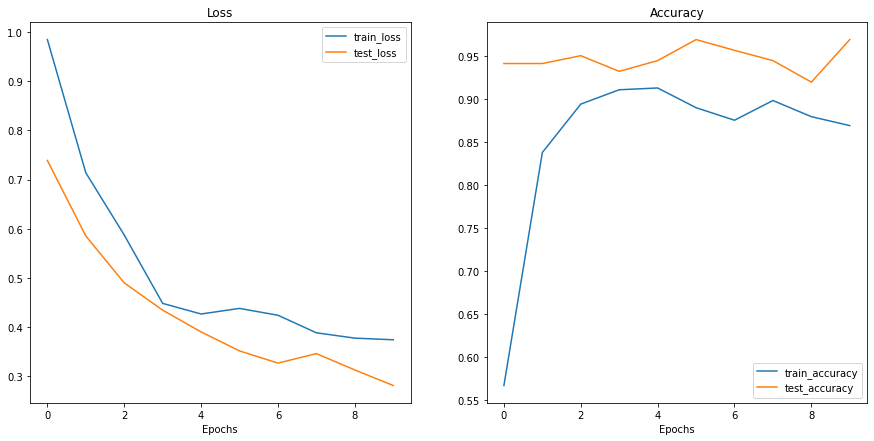

In [ ]:
from helper_functions import plot_loss_curves

plot_loss_curves(effnetb2_results)

### 3.4 Saving EffNetB2 feature extractor

In [ ]:
from going_modular.going_modular import utils

# Save the model
utils.save_model(model=effnetb2,
                 target_dir="models",
                 model_name="pretrained_effnet_b2_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models/pretrained_effnet_b2_feature_extractor_pizza_steak_sushi_20_percent.pth


### 3.5 Checking the size EffNetB2 feature extractor

Since one of our criteria for deploying a model to power FoodVision Mini is speed (~30FPS or better), let's check the size of our model.

Why check the size?

Well, while not always the case, the size of a model can influence its inference speed.

As in, if a model has more parameters, it generally performs more operations and each one of these operations requires some computing power.

And because we'd like our model to work on devices with limited computing power (e.g. on a mobile device or in a web browser), generally, the smaller the size the better (as long as it still performs well in terms of accuracy).

To check our model's size in bytes, we can use Python's `pathlib.Path.stat("path_to_model").st_size` and then we can convert it (roughly) to megabytes by dividing it by (1024*1024).

In [ ]:
from pathlib import Path
# Get the model size in bytes then convert to megabytes
pretrained_effnetb2_model_size = Path("/content/models/pretrained_effnet_b2_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly) 
print(f"Pretrained EffNetB2 feature extractor model size: {pretrained_effnetb2_model_size} MB")

Pretrained EffNetB2 feature extractor model size: 29 MB


### 3.6 Collecting EffNetB2 feature extractor stats

In [ ]:
# Count number of parameters in EffNetB2
effnetb2_total_params = sum(torch.numel(param) for param in effnetb2.parameters())
effnetb2_total_params

7705221

In [ ]:

# Create a dictionary with EffNetB2 statistics
effnetb2_stats = {"test_loss": effnetb2_results["test_loss"][-1],
                  "test_acc": effnetb2_results["test_acc"][-1],
                  "number_of_parameters": effnetb2_total_params,
                  "model_size (MB)": pretrained_effnetb2_model_size}
effnetb2_stats

{'test_loss': 0.28086444437503816,
 'test_acc': 0.96875,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29}

## 4.Creating a ViT feature extractor

In [ ]:
# Setup model weights
vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

# Transform
vit_transform = vit_weights.transforms()

# model
vit = torchvision.models.vit_b_16(weights=vit_weights)

# Freeze all 
for param in vit.parameters():
  param.requires_grad=False 



Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


  0%|          | 0.00/330M [00:00<?, ?B/s]

In [ ]:
torch.manual_seed(42)
vit.heads = nn.Sequential(
    nn.Linear(in_features=768,
              out_features=3)
)

In [ ]:
def create_vit_model(num_classes:int=3, 
                     seed:int=42):
    """Creates a ViT-B/16 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of target classes. Defaults to 3.
        seed (int, optional): random seed value for output layer. Defaults to 42.

    Returns:
        model (torch.nn.Module): ViT-B/16 feature extractor model. 
        transforms (torchvision.transforms): ViT-B/16 image transforms.
    """
    # Create ViT_B_16 pretrained weights, transforms and model
    weights = torchvision.models.ViT_B_16_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.vit_b_16(weights=weights)

    # Freeze all layers in model
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head to suit our needs (this will be trainable)
    torch.manual_seed(seed)
    model.heads = nn.Sequential(nn.Linear(in_features=768, # keep this the same as original model
                                          out_features=num_classes)) # update to reflect target number of classes
    
    return model, transforms

In [ ]:
# Create ViT model and transforms
vit, vit_transforms = create_vit_model(num_classes=3,
                                       seed=42)

### 4.1 Create DataLoaders for Vit

In [ ]:
train_dataloader_vit, test_dataloader_vit, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                       test_dir = test_dir,
                                                                                       transform=vit_transform,
                                                                                       batch_size=32)

### 4.2 Trining ViT feature extractor

In [ ]:
from going_modular.going_modular import engine

# Setup optimizer
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=1e-3)

# Setup loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Train ViT model
set_seeds()
vit_results = engine.train(model=vit,
                           train_dataloader=train_dataloader_vit,
                           test_dataloader=test_dataloader_vit,
                           epochs=10,
                           optimizer=optimizer, 
                           loss_fn=loss_fn,
                           device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7023 | train_acc: 0.7500 | test_loss: 0.2714 | test_acc: 0.9290
Epoch: 2 | train_loss: 0.2531 | train_acc: 0.9104 | test_loss: 0.1669 | test_acc: 0.9602
Epoch: 3 | train_loss: 0.1766 | train_acc: 0.9542 | test_loss: 0.1270 | test_acc: 0.9693
Epoch: 4 | train_loss: 0.1277 | train_acc: 0.9625 | test_loss: 0.1072 | test_acc: 0.9722
Epoch: 5 | train_loss: 0.1163 | train_acc: 0.9646 | test_loss: 0.0950 | test_acc: 0.9784
Epoch: 6 | train_loss: 0.1270 | train_acc: 0.9375 | test_loss: 0.0830 | test_acc: 0.9722
Epoch: 7 | train_loss: 0.0899 | train_acc: 0.9771 | test_loss: 0.0844 | test_acc: 0.9784
Epoch: 8 | train_loss: 0.0928 | train_acc: 0.9812 | test_loss: 0.0759 | test_acc: 0.9722
Epoch: 9 | train_loss: 0.0933 | train_acc: 0.9792 | test_loss: 0.0729 | test_acc: 0.9784
Epoch: 10 | train_loss: 0.0662 | train_acc: 0.9833 | test_loss: 0.0642 | test_acc: 0.9847


### 4.3 Inspecting ViT loss curves

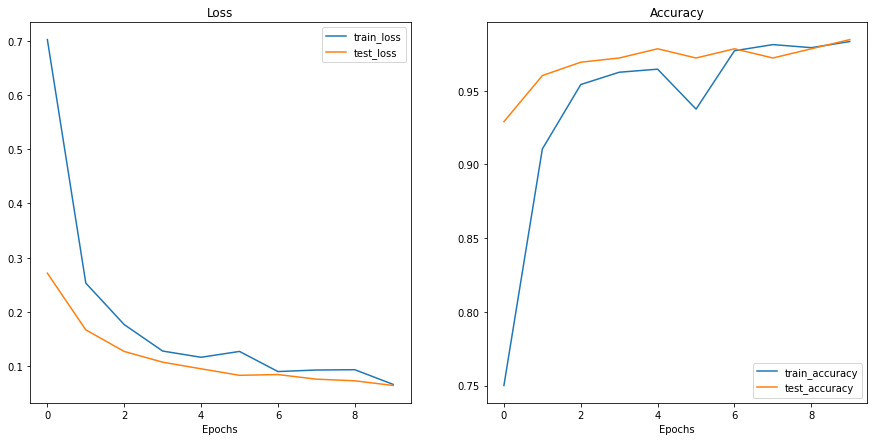

In [ ]:
from helper_functions import plot_loss_curves

plot_loss_curves(vit_results)

### 4.4 Saving ViT feature extractor

In [ ]:
from going_modular.going_modular import utils

utils.save_model(model=vit,
                 target_dir="models",
                 model_name="pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models/pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth


### 4.5 Checking the size of ViT Feature extractor


In [ ]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_vit_model_size = Path("models/pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly) 
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")

Pretrained ViT feature extractor model size: 327 MB


### 4.6 Collecting ViT feature extractor stas

In [ ]:
# Count number of parameters in ViT
vit_total_params = sum(torch.numel(param) for param in vit.parameters())
vit_total_params

85800963

In [ ]:
# Create ViT statistics dictionary
vit_stats = {"test_loss": vit_results["test_loss"][-1],
             "test_acc": vit_results["test_acc"][-1],
             "number_of_parameters": vit_total_params,
             "model_size (MB)": pretrained_vit_model_size}

vit_stats

{'test_loss': 0.06418210905976593,
 'test_acc': 0.984659090909091,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327}

## 5.Making predictions with our trained models and timing them.

In [ ]:
from pathlib import Path

# Get all test data paths
print(f"[INFO] Finding all filepaths ending with '.jpg' in directory: {test_dir}" )
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_data_paths[:3]

[INFO] Finding all filepaths ending with '.jpg' in directory: data/pizza_steak_sushi_20_percent/test


[PosixPath('data/pizza_steak_sushi_20_percent/test/steak/3479599.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/2752603.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/2069289.jpg')]

### 5.1 Creating a function to make predictions across the test dataset

In [ ]:
import pathlib
import torch

from PIL import Image
from timeit import default_timer as timer
from tqdm.auto import tqdm
from typing import List, Dict

# 1.Create a function to return a list of dictionaries
def pred_and_store(paths: List[pathlib.Path],
                   model: torch.nn.Module,
                   transform: torchvision.transforms,
                   class_names: List[str],
                   device: str = "cuda" if torch.cuda.is_available() else "cpu"):
  # 2.Create an empty list to store prediction dictionaries
  pred_list = []
  # 3. Loop through target paths
  for path in tqdm(paths):
    # 4.Create empty dictionary to store prediction information for each sample
    pred_dict = {}
    # 5.Get the sample path and ground truth class names
    pred_dict["image_path"] = path
    class_name = path.parent.stem
    pred_dict["class_name"] = class_name

    # 6.Start the prediction timer
    start_time = timer() 
    
    # 7.Open image path
    img = Image.open(path)

    # 8.Transform the image, add batch dimension and put image on target device
    transformed_image = transform(img).unsqueeze(0).to(device)

    # 9.Prepare model fore inference by sending it to target device
    model.to(device)  
    model.eval()

    # 10. Get prediction probability, prediction label and prediction class
    with torch.inference_mode():
      pred_logit = model(transformed_image) 
      pred_prob = torch.softmax(pred_logit, dim=1)
      pred_label = torch.argmax(pred_prob, dim=1)
      pred_class = class_names[pred_label.cpu()]

      # 11. Make sure things in the dictionary are on CPU(required for inspecting predictions later on)
      pred_dict['pred_prob'] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4) 
      pred_dict['pred_class'] = pred_class

      # 12. End the timer and calculate time per pred
      end_time = timer()
      pred_dict["time_for_pred"] = round(end_time-start_time, 4)
    # 13.Does the pred match the true label?
    pred_dict['correct'] = class_name == pred_class
    # 14. Add the dictionary to the list of preds
    pred_list.append(pred_dict)
  # 15.Return
  return pred_list

### 5.2 Making and timing predictions with EffNetB2

In [ ]:
# Make predictions across test dataset with EffNetB2
effnetb2_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                          model=effnetb2,
                                          transform=effnetb2_transforms,
                                          class_names=class_names,
                                          device="cpu") # make predictions on CPU 

  0%|          | 0/150 [00:00<?, ?it/s]

In [ ]:
# Inspect the first 2 prediction dictionaries
effnetb2_test_pred_dicts[:5]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/3479599.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.8793,
  'pred_class': 'steak',
  'time_for_pred': 0.3732,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/2752603.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.7526,
  'pred_class': 'steak',
  'time_for_pred': 0.1325,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/2069289.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.8372,
  'pred_class': 'steak',
  'time_for_pred': 0.1399,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/40947.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.7651,
  'pred_class': 'steak',
  'time_for_pred': 0.1336,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/1285886.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.8868,
  'pred_class': 'steak',
  'time_for_pr

In [ ]:
import pandas as pd
effnetb2_test_pred_df = pd.DataFrame(effnetb2_test_pred_dicts)
effnetb2_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/steak/3...,steak,0.8793,steak,0.3732,True
1,data/pizza_steak_sushi_20_percent/test/steak/2...,steak,0.7526,steak,0.1325,True
2,data/pizza_steak_sushi_20_percent/test/steak/2...,steak,0.8372,steak,0.1399,True
3,data/pizza_steak_sushi_20_percent/test/steak/4...,steak,0.7651,steak,0.1336,True
4,data/pizza_steak_sushi_20_percent/test/steak/1...,steak,0.8868,steak,0.1313,True


In [ ]:
effnetb2_test_pred_df.tail()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
145,data/pizza_steak_sushi_20_percent/test/sushi/1...,sushi,0.9557,sushi,0.1420,True
146,data/pizza_steak_sushi_20_percent/test/sushi/1...,sushi,0.8828,sushi,0.1279,True
147,data/pizza_steak_sushi_20_percent/test/sushi/8...,sushi,0.5130,sushi,0.1308,True
148,data/pizza_steak_sushi_20_percent/test/sushi/2...,sushi,0.9198,sushi,0.1316,True
149,data/pizza_steak_sushi_20_percent/test/sushi/2...,sushi,0.8302,sushi,0.1349,True


In [ ]:
# Check number of correct predictions
effnetb2_test_pred_df.correct.value_counts()

True     145
False      5
Name: correct, dtype: int64

In [ ]:
# Find the average time per prediction 
effnetb2_average_time_per_pred = round(effnetb2_test_pred_df.time_for_pred.mean(), 4)
print(f"EffNetB2 average time per prediction: {effnetb2_average_time_per_pred} seconds")

EffNetB2 average time per prediction: 0.1327 seconds


In [ ]:
# Add EffNetB2 average prediction time to stats dictionary 
effnetb2_stats["time_per_pred_cpu"] = effnetb2_average_time_per_pred
effnetb2_stats

{'test_loss': 0.28086444437503816,
 'test_acc': 0.96875,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29,
 'time_per_pred_cpu': 0.1327}


### 5.3 Making and timing predictions with ViT

In [ ]:
vit_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                     model=vit,
                                     transform=vit_transform,
                                     class_names=class_names,
                                     device='cpu')

  0%|          | 0/150 [00:00<?, ?it/s]

In [ ]:
# Check the first couple of ViT predictions on the test dataset
vit_test_pred_dicts[:2]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/3479599.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.8956,
  'pred_class': 'steak',
  'time_for_pred': 0.8354,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/2752603.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.9971,
  'pred_class': 'steak',
  'time_for_pred': 0.7233,
  'correct': True}]

In [ ]:
# Turn vit_test_pred_dicts into a DataFrame
import pandas as pd
vit_test_pred_df = pd.DataFrame(vit_test_pred_dicts)
vit_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/steak/3...,steak,0.8956,steak,0.8354,True
1,data/pizza_steak_sushi_20_percent/test/steak/2...,steak,0.9971,steak,0.7233,True
2,data/pizza_steak_sushi_20_percent/test/steak/2...,steak,0.9463,steak,0.6636,True
3,data/pizza_steak_sushi_20_percent/test/steak/4...,steak,0.9898,steak,0.6552,True
4,data/pizza_steak_sushi_20_percent/test/steak/1...,steak,0.9719,steak,0.6478,True


In [ ]:
# Count the number of correct predictions
vit_test_pred_df.correct.value_counts()

True     148
False      2
Name: correct, dtype: int64

In [ ]:
# Calculate average time per prediction for ViT model
vit_average_time_per_pred = round(vit_test_pred_df.time_for_pred.mean(), 4)
print(f"ViT average time per prediction: {vit_average_time_per_pred} seconds")

ViT average time per prediction: 0.7184 seconds


In [ ]:
# Add average prediction time for ViT model on CPU
vit_stats["time_per_pred_cpu"] = vit_average_time_per_pred
vit_stats

{'test_loss': 0.06418210905976593,
 'test_acc': 0.984659090909091,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327,
 'time_per_pred_cpu': 0.7184}

## 6.Comparing model results, prediction times and size

In [ ]:
# Turn stat dictionaries into DataFrame
df = pd.DataFrame([effnetb2_stats, vit_stats])  

# Add Column for model names
df['model'] = ['EffNetB2', 'ViT']

# Convert accuracy to percentages 
df['test_acc'] = round(df['test_acc']*100, 2)
df

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu,model
0,0.280864,96.88,7705221,29,0.1327,EffNetB2
1,0.064182,98.47,85800963,327,0.7184,ViT


In [ ]:
# Compare ViT to EffNetB2 across different characteristics
pd.DataFrame(data=(df.set_index("model").loc["ViT"] / df.set_index("model").loc["EffNetB2"]), # divide ViT statistics by EffNetB2 statistics
             columns=["ViT to EffNetB2 ratios"]).T

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu
ViT to EffNetB2 ratios,0.228516,1.016412,11.135432,11.275862,5.413715


## 7.Bringing FoodVision Mini to life by creating a Gradio demo

In [ ]:
# Import/install Gradio
try:
  import gradio as gr
except:
  !pip -q install gradio
  import gradio as gr 

print(f"Gradio version: {gr.__version__}")

     |████████████████████████████████| 5.3 MB 39.5 MB/s 
     |████████████████████████████████| 2.3 MB 59.0 MB/s 
     |████████████████████████████████| 270 kB 71.7 MB/s 
     |████████████████████████████████| 54 kB 423 kB/s 
     |████████████████████████████████| 84 kB 2.7 MB/s 
     |████████████████████████████████| 55 kB 2.5 MB/s 
     |████████████████████████████████| 84 kB 2.8 MB/s 
     |████████████████████████████████| 212 kB 70.5 MB/s 
     |████████████████████████████████| 112 kB 73.9 MB/s 
     |████████████████████████████████| 57 kB 1.3 MB/s 
     |████████████████████████████████| 63 kB 1.1 MB/s 
     |████████████████████████████████| 80 kB 1.8 MB/s 
     |████████████████████████████████| 68 kB 4.9 MB/s 
     |████████████████████████████████| 46 kB 3.7 MB/s 
     |████████████████████████████████| 4.0 MB 62.5 MB/s 
     |████████████████████████████████| 594 kB 77.9 MB/s 
     |████████████████████████████████| 856 kB 65.1 MB/s 
Gradio version: 3.4.0


### 7.1 Creating a function to map our inputs and outputs.

```
input: image -> transform -> predict with EffNetB2 -> output: pred, pred prob, time taken
```

In [ ]:
# Put EffNetB2 on CPU
effnetb2.to("cpu")

# Check the device
next(iter(effnetb2.parameters())).device

device(type='cpu')

In [ ]:
from typing import Tuple, Dict

def predict(img):
    """Transforms and performs a prediction on img and returns prediction and time taken.
    """
    # Start the timer
    start_time = timer()

    # Transform the target image and add a batch dimension
    img = effnetb2_transforms(img).unsqueeze(0)

    # Put model into evaluation mode and turn on inference mode
    effnetb2.eval()
    with torch.inference_mode():
      pred_probs = torch.softmax(effnetb2(img), dim=1)
    
    # Create a prediction label and prediction probability dictionary
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5) 

    # Return the prediction dictionary and prediction time
    return pred_labels_and_probs, pred_time

In [ ]:
import random
from PIL import Image

# Get a list of all test image filepaths
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))

# Randomly select a test image path
random_image_path = random.sample(test_data_paths, k=1)[0]

# Open the target image
image = Image.open(random_image_path)
print(f"[INFO] Predicting on image at path: {random_image_path}\n")

# Predict on the target image and print out the outputs
pred_dict, pred_time = predict(img=image)
print(f"Prediction label and probability dictionary: \n{pred_dict}")
print(f"Prediction time: {pred_time} seconds")

[INFO] Predicting on image at path: data/pizza_steak_sushi_20_percent/test/pizza/3486640.jpg

Prediction label and probability dictionary: 
{'pizza': 0.9734876155853271, 'steak': 0.014494392089545727, 'sushi': 0.012018009088933468}
Prediction time: 0.21058 seconds


### 7.3 Creating a list of example images

In [ ]:
# Create a list of example inputs to our Gradio demo
example_list = [[str(filepath)] for filepath in random.sample(test_data_paths, k=3)]
example_list

[['data/pizza_steak_sushi_20_percent/test/pizza/771336.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/pizza/2901001.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/pizza/3174637.jpg']]

### 7.4 Building a Gradio interface

```
input: image -> transform -> predict with EffNetB2 -> outpout: pred, pred_prob, time taken
```

In [ ]:
import gradio as gr

# Create title, description and article strings
title = "FoodVision Mini 🍕🥩🍣"
description = "An EfficientNetB2 feature extractor computer vision model to classify images of food as pizza, steak or sushi."
article = "Created at [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/)."

# Create the Gradio demo
demo = gr.Interface(fn=predict,
                    inputs=gr.Image(type='pil'),
                    outputs=[gr.Label(num_top_classes=3, label='Predictions'),
                             gr.Number(label='Prediction time (s)')],
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

#  Launch the demo!
# demo.launch(debug=False, # print errors locally?
#             share=True) # generate a publically shareable URL?

## 8.Turning our FoodVision Mini Gradio Demo into a deployable app

We've seen our FoodVision Mini model come to life through a Gradio demo.

But what if we wanted to share it with our friends?

Well, we could use the provided Gradio link, however, the shared link only lasts for 72-hours.

To make our FoodVision Mini demo more permanent, we can package it into an app and upload it to Hugging Face Spaces.

### 8.1 What is Hugging Face Spaces?

Hugging Face Spaces is a resource that allows you to host and share machine learning apps.

Building a demo is one of the best ways to showcase and test you've done.

And Spaces allows you to do just that.

You can think of Hugging Face as the Github of Machine learning

If having a good Github portfolio showcases your coding abilitites, having a good Hugging Face portfolio can showcase our machine learning abilities.

### 8.2 Deployed Gradio app struture

To upload our demo Gradio app, we'll want to put everything relating to it into a single directory.

For example, our demo might live at the path demos/foodvision_mini/ with the file structure:

```
demos/
└── foodvision_mini/
    ├── 09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth
    ├── app.py
    ├── examples/
    │   ├── example_1.jpg
    │   ├── example_2.jpg
    │   └── example_3.jpg
    ├── model.py
    └── requirements.txt
```

### 8.3 Creating a `demos` folder to store our FoodVision Mini app Files.

In [ ]:
import shutil
from pathlib import Path  

# Create FoodVision mini demo path
foodvision_mini_demo_path = Path("demos/foodvision_mini/")

# Remove files that might already exist there and create new directory
if foodvision_mini_demo_path.exists():
  shutil.rmtree(foodvision_mini_demo_path)
  foodvision_mini_demo_path.mkdir(parents=True,
                                  exist_ok=True)
else:
  # If the file doesn't exist, create it anyway
  foodvision_mini_demo_path.mkdir(parents=True,
                                  exist_ok=True)  

# Check what's in the folder
!ls demos/foodvision_mini/

### 8.4 Creating a folder of example images to use with our FoodVision Mini demo

Now we've got a directory to store our FoodVision Mini demo files, let's add some examples to it.

Three example images from the test dataset should be enough

To do so we'll:
1. Create and `examples/` directory within the `demos/foodvision_mini` directory
2. Choose three random images from the test dataset and collect their paths in a list.
3. Copy the three random images from the test dataset to the `demos/foodvision_mini/example/` directory

In [ ]:
import shutil 
from pathlib import Path   

# 1. Create an example directory
foodvision_mini_examples_path = foodvision_mini_demo_path / "examples"
foodvision_mini_examples_path.mkdir(parents=True,
                                    exist_ok=True)

# 2. Collect three random test dataset image paths
foodvision_mini_examples = [Path('data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg')]

# 3. Copy the three random images to the examples directory
for example in foodvision_mini_examples:
    destination = foodvision_mini_examples_path / example.name
    print(f"[INFO] Copying {example} to {destination}")
    shutil.copy2(src=example, dst=destination)

[INFO] Copying data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg to demos/foodvision_mini/examples/592799.jpg
[INFO] Copying data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg to demos/foodvision_mini/examples/3622237.jpg
[INFO] Copying data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg to demos/foodvision_mini/examples/2582289.jpg


In [ ]:
import os

# Get example filepaths in a list of lists
example_list = [["examples/" + example] for example in os.listdir(foodvision_mini_examples_path)]
example_list

[['examples/592799.jpg'], ['examples/2582289.jpg'], ['examples/3622237.jpg']]

### 8.5 Moving our trained EffNetB2 model to our FoodVision Mini demo directory

In [ ]:
import shutil

# Create a source path for our target model
effnetb2_foodvision_mini_model_path = "models/pretrained_effnet_b2_feature_extractor_pizza_steak_sushi_20_percent.pth"

# Create a destination path for our target model 
effnetb2_foodvision_mini_model_destination = foodvision_mini_demo_path / effnetb2_foodvision_mini_model_path.split("/")[1]

# Try to move the file
try:
    print(f"[INFO] Attempting to move {effnetb2_foodvision_mini_model_path} to {effnetb2_foodvision_mini_model_destination}")
    
    # Move the model
    shutil.move(src=effnetb2_foodvision_mini_model_path, 
                dst=effnetb2_foodvision_mini_model_destination)
    
    print(f"[INFO] Model move complete.")

# If the model has already been moved, check if it exists
except:
    print(f"[INFO] No model found at {effnetb2_foodvision_mini_model_path}, perhaps its already been moved?")
    print(f"[INFO] Model exists at {effnetb2_foodvision_mini_model_destination}: {effnetb2_foodvision_mini_model_destination.exists()}")

[INFO] Attempting to move models/pretrained_effnet_b2_feature_extractor_pizza_steak_sushi_20_percent.pth to demos/foodvision_mini/pretrained_effnet_b2_feature_extractor_pizza_steak_sushi_20_percent.pth
[INFO] Model move complete.


### 8.6 Turning our EffNetB2 model into a Python script(`model.py`)

In [ ]:
%%writefile demos/foodvision_mini/model.py
import torch 
import torchvision
from torch import nn

def create_effnetb2_model(num_classes: int=3,
                          seed: int=42):
    """
    Creates an EfficientNetB2 feature extractor model and transforms.

    Args:
      num_classes(int, optional): number of classes in the classifier head.
      seed(int, optional): random seed value. Defaults to 42 
    
    Returns:
      model(torch.nn.Module): EffNetB2 feature extractor model.
      transforms (torchvision.transforms): EffNetB2 image transforms.
    """

    # Create EffNetB2 pretrained weights, transforms and model.
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad = False 
    
    # Change classifier head with random seed for reproducibility 
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
      nn.Dropout(p=0.3, inplace=True),
      nn.Linear(in_features=1408, 
                out_features=num_classes)
    )
    return model, transforms
    

Writing demos/foodvision_mini/model.py


### 8.7 Turning our FoodVision Mini Gradio app in a Python script(`app.py`)

In [ ]:
%%writefile demos/foodvision_mini/app.py

# 1. Imports and class names setup 
import gradio as gr 
import os
import torch 

from model import create_effnetb2_model 
from timeit import default_timer as timer 
from typing import Tuple, Dict 

# Setup class names 
class_names = ['pizza', 'steak', 'sushi']

# 2. Model and transforms preparation

# Create EffNetB2 model 
effnetb2, effnetb2_transforms = create_effnetb2_model(
  num_classes=3
)

# Load saved weights 
effnetb2.load_state_dict(
  torch.load(
    f="pretrained_effnet_b2_feature_extractor_pizza_steak_sushi_20_percent.pth",
    map_location=torch.device('cpu')
  )
)

# 3. Prediction function 

# Create predict function 
def predict(img) -> Tuple[Dict, float]:
    """
    Transforms and performs a prediction on img and returns prediction and time taken.
    """
    # Start the timer 
    start_time = timer()

    # Transform the target image and add a batch dimension 
    img = effnetb2_transforms(img).unsqueeze(0)

    # Put model into a evaluation mode and turn on inference mode.
    effnetb2.eval()
    with torch.inference_mode():
      # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
      pred_probs = torch.softmax(effnetb2(img), dim=1)
    
    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)

    # Return the prediction dictionary and prediction time 
    return pred_labels_and_probs, pred_time 

# 4.Gradio app 

# Create title, description and article strings 
title = "FoodVision Mini 🍕🥩🍣"
description = "An EfficientNetB2 feature extractor computer vision model to classify images of food as pizza, steak or sushi."
article = "Created at [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/)."

# Create example list from "example/" directory 
example_list = [["examples/" + example] for example in os.listdir("examples")]

# Create the gradio demo 
demo = gr.Interface(fn=predict,
                    inputs=gr.Image(type='pil'),
                    outputs=[gr.Label(num_top_classes=3, label='Predictions'),
                             gr.Number(label='Prediction time(s)')],
                    # Create examples list from "examples/" directory
                    examles=example_list,
                    title=title,
                    description=description,
                    article=article)

# Launch the demo 
demo.launch()

Writing demos/foodvision_mini/app.py


### 8.8 Creating a requirements file for FoodVision Mini(`requirements.txt`)

In [ ]:
%%writefile demos/foodvision_mini/requirements.txt
torch==1.12.0
torchvision==0.13.0
gradio==3.1.4

Writing demos/foodvision_mini/requirements.txt


## 9.Deploying our FoodVision Mini app to HuggingFace Spaces

## 9.1 Downloading our FoodVision Mini app files

In [ ]:
!ls demos/foodvision_mini

app.py
examples
model.py
pretrained_effnet_b2_feature_extractor_pizza_steak_sushi_20_percent.pth
requirements.txt


In [ ]:
# Change into and then zip the foodvision_mini folder but exclude certain files
!cd demos/foodvision_mini && zip -r ../foodvision_mini.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

# Download the zipped FoodVision Mini app (if running in Google Colab)
try:
    from google.colab import files
    files.download("demos/foodvision_mini.zip")
except:
    print("Not running in Google Colab, can't use google.colab.files.download(), please manually download.")

  adding: app.py (deflated 56%)
  adding: examples/ (stored 0%)
  adding: examples/592799.jpg (deflated 1%)
  adding: examples/2582289.jpg (deflated 17%)
  adding: examples/3622237.jpg (deflated 0%)
  adding: model.py (deflated 55%)
  adding: pretrained_effnet_b2_feature_extractor_pizza_steak_sushi_20_percent.pth (deflated 8%)
  adding: requirements.txt (deflated 4%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>